## Results

******************** Hyperparameters ********************
activation: gelu
affine: 0
batch_size: 12
c_out: 1
checkpoints: ./checkpoints/ctg
d_ff: 256
d_layers: 1
d_model: 128
data: CTG
data_path: X.npy
dec_in: 2
decomposition: 0
des: Exp
devices: 0,1,2,3
distil: True
do_predict: False
dropout: 0.5
e_layers: 3
embed: timeF
embed_type: 0
enc_in: 2
factor: 1
fc_dropout: 0.25
features: M
freq: h
gpu: 0
head_dropout: 0.0
individual: 0
is_training: 1
itr: 1
kernel_size: 25
learning_rate: 0.0001
loss: cross_entropy
lradj: type3
model: PatchTST
model_id: ctg_960
moving_avg: 25
n_heads: 16
num_classes: 2
num_workers: 1
output_attention: False
padding_patch: end
patch_len: 16
patience: 30
pct_start: 0.3
random_seed: 2021
revin: 1
root_path: ./dataset/
seq_len: 960
stride: 8
subtract_last: 0
target: OT
test_flop: False
train_epochs: 100
use_amp: False
use_gpu: True
use_multi_gpu: False

******************* Training Results ********************

Total Training Time: 0:38:42.575889


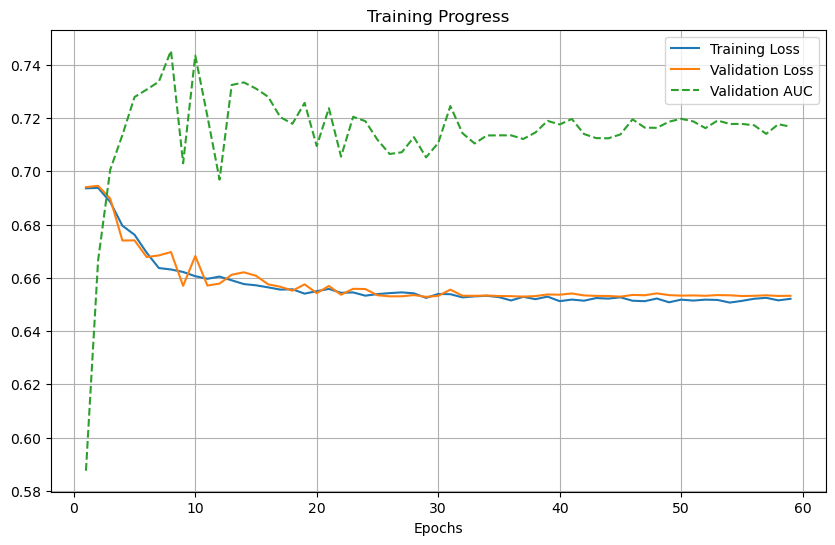


******************** Testing Results ********************
Accuracy: 0.6559766763848397
Precision: 0.8429172510518934
Recall: 0.31548556430446195
F1 Score: 0.4591291061879297
AUC: 0.7047637023662409


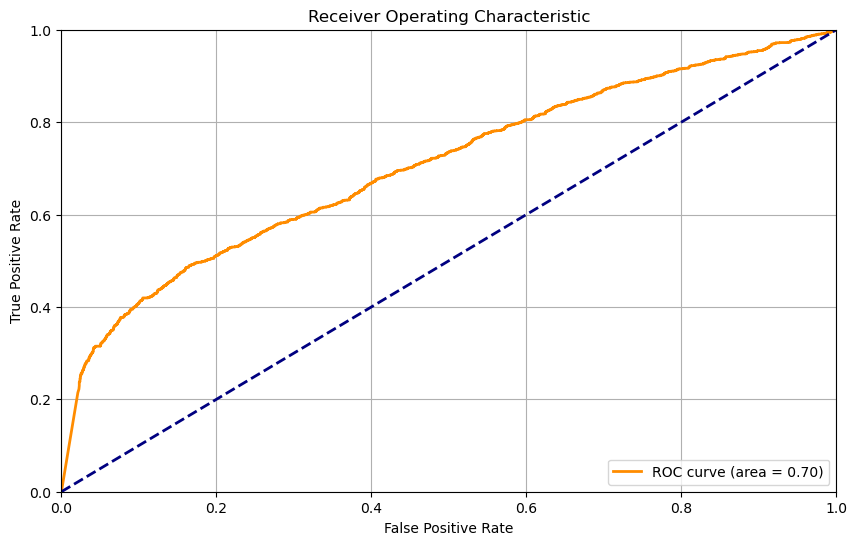

In [3]:
import os
import shutil
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import roc_curve, auc

# manually set path of subdir in jResults
# subdir_path = './jResults/xxxxx'

# or find the path of latest subdir in jResults 
subdirs = [d for d in os.listdir('PatchTST_supervised/jResults/') if os.path.isdir(os.path.join('PatchTST_supervised/jResults/', d))]
subdirs_sorted = sorted(subdirs, key=lambda x: datetime.strptime(x, '%Y-%m-%d %H%M'))
subdir_path = os.path.join('PatchTST_supervised/jResults/', subdirs_sorted[-1])

# Define file paths from the latest subdirectory
log_file_path = os.path.join(subdir_path, 'PatchTST_ctg_960.log')
preds_file_path = os.path.join(subdir_path, 'preds.npy')
trues_file_path = os.path.join(subdir_path, 'trues.npy')
checkpoint_path = os.path.join(subdir_path, 'checkpoint.pth')

# Initialize variables to store log data
hyperparameters = {}
train_losses = []
val_losses = []
val_aucs = []
epochs = []
train_times = []
test_metrics = None

# Read and parse the log file
with open(log_file_path, 'r') as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        if i == 1 and line.startswith("Namespace("):
            hyperparameter_string = line.strip().replace("Namespace(", "").replace(")", "")
            hyperparameter_pairs = hyperparameter_string.split(", ")
            for item in hyperparameter_pairs:
                if "=" in item:
                    key, value = item.split("=", 1)
                    hyperparameters[key.strip()] = value.strip().strip("'")  # Remove quotes around string values

        # Extract training/validation losses
        if "Train Loss" in line:
            match = re.findall(r'Epoch: (\d+).*Train Loss: ([\d.]+) Vali Loss: ([\d.]+) Vali AUC: ([\d.]+)', line)
            if match:
                epoch, train_loss, val_loss, val_auc = match[0]
                epochs.append(int(epoch))
                train_losses.append(float(train_loss))
                val_losses.append(float(val_loss))
                val_aucs.append(float(val_auc))
        
        # Extract training time
        if "cost time" in line:
            match = re.findall(r'Epoch: (\d+) cost time: ([\d.]+)', line)
            if match:
                epoch, time_taken = match[0]
                train_times.append(float(time_taken))
        
        # Extract final test metrics
        if "accuracy" in line:
            match = re.findall(r'accuracy:([\d.]+), precision:([\d.]+), recall:([\d.]+), f1:([\d.]+), auc:([\d.]+)', line)
            if match:
                accuracy, precision, recall, f1, auc_score = match[0]
                test_metrics = {
                    'Accuracy': float(accuracy),
                    'Precision': float(precision),
                    'Recall': float(recall),
                    'F1 Score': float(f1),
                    'AUC': float(auc_score)
                }

# Print the hyperparameters
print("******************** Hyperparameters ********************")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

print("\n******************* Training Results ********************")

# Calculate and print total training time
total_train_time = sum(train_times)
train_time_hms = str(timedelta(seconds=total_train_time))
print(f"\nTotal Training Time: {train_time_hms}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Print the final test results
if test_metrics:
    print("\n******************** Testing Results ********************")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value}")

# Load the saved predictions and true labels
if os.path.exists(preds_file_path) and os.path.exists(trues_file_path):
    preds = np.load(preds_file_path)
    trues = np.load(trues_file_path)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(trues, preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
else:
    print("Predictions and true labels not found. ROC curve cannot be plotted.")

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from IPython.display import clear_output

In [2]:
# Load the data
X = np.load('../gabriel_data/X.npy')
y = np.load('../gabriel_data/y.npy')
dataset = pd.read_csv('../gabriel_data/clinical_data.csv')

print(X.shape)
print(y.shape)
print(dataset.shape)

(20589, 960, 2)
(20589,)
(20589, 7)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

print(f'Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

Training set: X_train shape: (16471, 960, 2), y_train shape: (16471,)
Test set: X_test shape: (4118, 960, 2), y_test shape: (4118,)


In [4]:
# Merge X, y, and dataset into a single DataFrame
X_list = [x for x in X]
y_list = y.tolist()
dataset['input_signals'] = X_list
dataset['label'] = y_list

In [5]:
# Define the columns of interest
columns_of_interest = ['OMAGE', 'OPAR1', 'OPAR2', 'RecGest', 'Diff', 'BMI_M', 'OSEX']

# Function to print stats for a given dataset
def print_stats(df, label):
    print(f"-------------------- Label {label} --------------------")
    df = df[df['label'] == label]
    count = len(df)
    print(f"Count: {count}")
    
    for col in columns_of_interest:
        if df[col].dtype == 'object' or len(df[col].unique()) <= 10:
            unique_values = df[col].unique()
            print(f"{col}: {len(unique_values)} unique values ({', '.join(map(str, unique_values))})")
        else:
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            print(f"{col}: {min_val:.2f} - {max_val:.2f} (Mean: {mean_val:.2f})")
    
    print("\n")

print_stats(dataset, 0)
print_stats(dataset, 1) 

-------------------- Label 0 --------------------
Count: 10890
OMAGE: 18.00 - 49.00 (Mean: 30.61)
OPAR1: 7 unique values (1.0, 0.0, 4.0, 2.0, 3.0, 6.0, 5.0)
OPAR2: 10 unique values (0.0, 1.0, 2.0, 5.0, 3.0, 7.0, 4.0, 6.0, 14.0, 8.0)
RecGest: 27.00 - 41.00 (Mean: 34.85)
Diff: 1.00 - 2618.00 (Mean: 682.64)
BMI_M: 15.55 - 40.00 (Mean: 25.71)
OSEX: 2 unique values (1.0, 0.0)


-------------------- Label 1 --------------------
Count: 9699
OMAGE: 15.00 - 49.00 (Mean: 30.70)
OPAR1: 7 unique values (4.0, 1.0, 2.0, 0.0, 3.0, 5.0, 6.0)
OPAR2: 0.00 - 9.00 (Mean: 0.48)
RecGest: 27.00 - 41.00 (Mean: 34.76)
Diff: 0.00 - 168.00 (Mean: 62.35)
BMI_M: 15.42 - 39.82 (Mean: 26.03)
OSEX: 2 unique values (1.0, 0.0)




In [6]:
np.unique(y, return_counts=True)

(array([0, 1]), array([10890,  9699]))

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)